# Flight Price Prediction

# Contents <a id='back'></a>

* [1. Introduction](#intro)
* [2. Initialisation](#init)
* [3. Data Exploration and Preprocessing](#data_exploration)
* [4. Exploratory Data Analysis (EDA)](#eda)
* [5. Modeling](#modeling)
* [6. Model Evaluation](#evaluation)
* [7. Conclusion](#conclusion)

##  1. Introduction <a id='intro'></a>

Fly Anywhere is an Indian travel agency. The company wants to know if a machine learning algorithm can find out the future ticket prices for the domestic flights so that they can plan their travel package pricing properly.

### 1.1 Purpose

This project aims to build a regression model to predict the domestic flight ticket prices in Indian.

[Back to Contents](#back)

## 2. Initialisation <a id='init'></a>

In [1]:
# Data manipulation and prerocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import plot_importance
from tqdm.auto import tqdm

# Machine Learning Model
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import LearningRateScheduler

import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader

# Model selection and evaluation
from optunaopt import sklearn_opt
from sklearn.metrics import mean_absolute_error
import pickle

[Back to Contents](#back)

## 3. Data Exploration and Preprocessing <a id='data_exploration'></a>

In [2]:
# Load the dataset
df = pd.read_csv('flights.csv', index_col=[0])

In [3]:
# Have a look at the dataset
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [4]:
# Check the shape
df.shape

(300153, 11)

The dataset has 300153 rows of flight ticket purchase records in India and 12 columns of relevant information.

**Description of data**

*Features*
- `airline`: The name of the airline company.
- `flight`: The plane's flight code.
- `source_city`: City from which the flight takes off.
- `departure_time`: The departure time of a flight.
- `stops`: The number of stops between the source and the destination cities.
- `arrival_time`: The arrival time of a flight.
- `destination_city`: City where the flight will land.
- `class`: The seat class.
- `duration`: Amount of time taken in hours to travel between two cities.
- `days_left`: The number of days left to departure at the time booking the ticket.

*Target*
- `price`: The ticket price. 

In [5]:
# Check for duplicates
df.duplicated().sum()

0

In [6]:
# Check if there is any missing value
df.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

The dataset has no duplicated row and missing value.

In [7]:
# Check the data types
df.dtypes

airline              object
flight               object
source_city          object
departure_time       object
stops                object
arrival_time         object
destination_city     object
class                object
duration            float64
days_left             int64
price                 int64
dtype: object

All the data types are correct.

In [8]:
# Look at the statictical summary
df.describe(include='all')

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153,300153,300153,300153,300153,300153,300153,300153,300153.000000,300153.000000,300153.000000
unique,6,1561,6,6,3,6,6,2,NaN,NaN,NaN
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN
freq,127859,3235,61343,71146,250863,91538,59097,206666,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.221021,26.004751,20889.660523
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.191997,13.561004,22697.767366
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,1.000000,1105.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830000,15.000000,4783.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.250000,26.000000,7425.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.170000,38.000000,42521.000000


From a overall view, the dataset has no obvious anomalies or outliers.

Since the `flight` feature cannot predict the price, this column will be dropped.

In [9]:
# Drop the flight feature
df.drop(columns=['flight'], inplace=True)

In [10]:
# Check if the column is dropped
df.head(3)

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956


[Back to Contents](#back)

## 4. Exploratory Data Analysis (EDA) <a id='eda'></a>

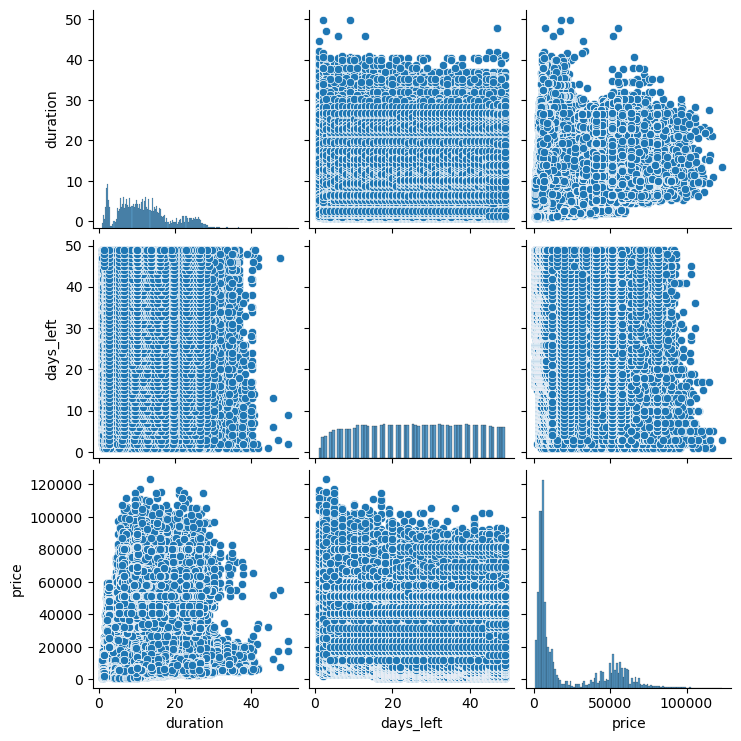

In [11]:
# Have a look at the pairplot of the numerical columns
sns.pairplot(df);

No obvious pattern can be found between the price and the numerical features.

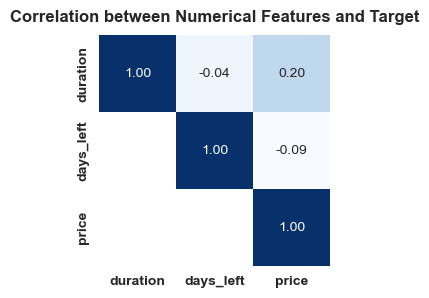

In [12]:
# Show the correlation of the numerical variables
sns.set_style('white')
plt.figure(figsize=(3,3))

corr_data = df.select_dtypes(np.number).corr()
mask = np.tril(np.ones(corr_data.shape, dtype=bool), k=-1)

sns.heatmap(corr_data, annot=True, fmt='.2f', mask=mask,
            cmap='Blues', square=True, cbar=False)

plt.title('Correlation between Numerical Features and Target',
          fontsize=12, fontweight='bold', y=1.02)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()

As expected, the numerical features have weak linear relationships with the target `price`.

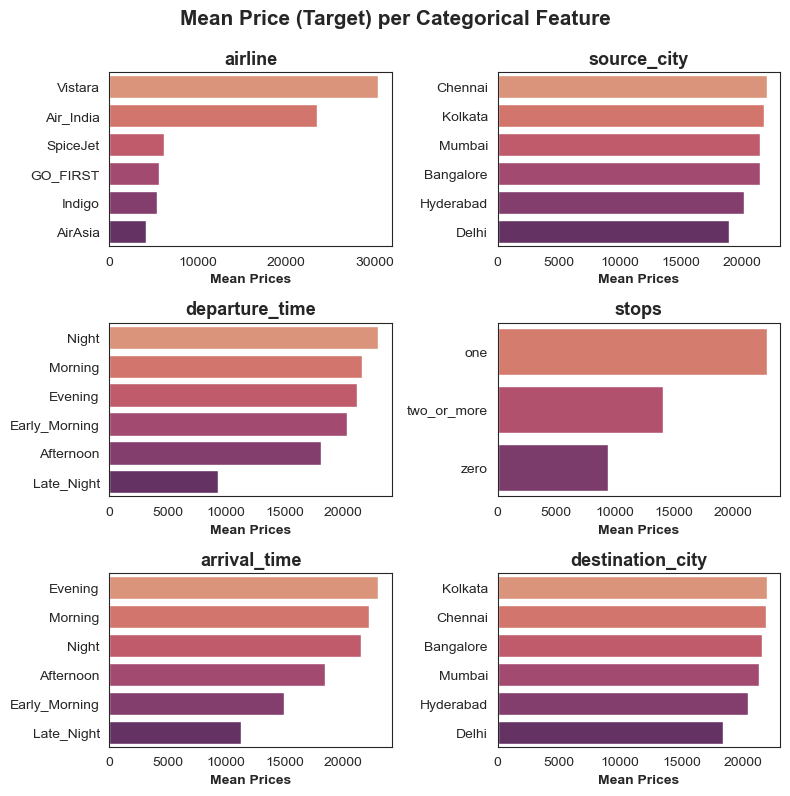

In [13]:
# Plot bar charts to show the relationship between the categorical features and the price
categorical_features = [col for col in df.columns if df[col].dtypes == 'object']
target = 'price'

nrows, ncols = 3, 2
sns.set_style('white')
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 8))

plt.suptitle('Mean Price (Target) per Categorical Feature',
             fontsize=15, fontweight='bold', y=0.99)

for i in range(nrows):
    for j in range(ncols):
        col_name = categorical_features[i*ncols + j]
        plot = df.groupby(col_name)['price'].mean()
        plot = plot.sort_values(ascending=False).to_frame()

        ax = axs[i][j]
        palette = sns.color_palette('flare', n_colors=len(plot))
        sns.barplot(data=plot, y=col_name, x=target, palette=palette, hue=col_name, ax=ax)
        ax.set_title(col_name, fontsize=13, fontweight='bold')
        ax.set_ylabel('')
        ax.set_xlabel('Mean Prices', fontweight='bold')
        
                
plt.tight_layout()
plt.show()

Except the `source_city` and `destination_city`, the other categorical features are good predictors for ticket prices.

[Back to Contents](#back)

## 5. Modeling <a id='modeling'></a>

The following models will be developed

- Linear Regression
- LightGBM
- Neural Network

The performance of the model with be evaluate by the mean absolute error (MAE) metric.

In [14]:
# One-hot encode the categorical features
df_ohe = pd.get_dummies(df, dtype=int)

In [15]:
# Get the features and target
X = df_ohe.drop(columns=['price']).values
X_lgbm = df.drop(columns=['price'])
X_lgbm[categorical_features] = X_lgbm[categorical_features].astype('category')
y = df_ohe['price'].values

In [16]:
# Split the dataset into train:val:test = 70:15:15
X_train, X_test, X_train_lgbm, X_test_lgbm, y_train, y_test = train_test_split(
    X, X_lgbm, y, test_size=0.15, random_state=42
)
X_train, X_val, X_train_lgbm, X_val_lgbm, y_train, y_val = train_test_split(
    X_train, X_train_lgbm, y_train, test_size=3/17, random_state=42
)
print('Shape of X_train:', X_train.shape)
print('Shape of X_train_lgbm:', X_train_lgbm.shape)
print('Shape of y_train:', y_train.shape)
print()
print('Shape of X_val:', X_val.shape)
print('Shape of X_val_lgbm:', X_val_lgbm.shape)
print('Shape of y_val:', y_val.shape)
print()
print('Shape of X_test:', X_test.shape)
print('Shape of X_test_lgbm:', X_test_lgbm.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (210107, 37)
Shape of X_train_lgbm: (210107, 9)
Shape of y_train: (210107,)

Shape of X_val: (45023, 37)
Shape of X_val_lgbm: (45023, 9)
Shape of y_val: (45023,)

Shape of X_test: (45023, 37)
Shape of X_test_lgbm: (45023, 9)
Shape of y_test: (45023,)


In [17]:
# Normalise the numerical features
sc = StandardScaler()
X_train[:, :2] = sc.fit_transform(X_train[:, :2])
X_val[:, :2] = sc.transform(X_val[:, :2])
X_test[:, :2] = sc.transform(X_test[:, :2])

numerical_features = ['duration', 'days_left']
sc_lgbm = StandardScaler()
X_train_lgbm[numerical_features] = sc_lgbm.fit_transform(X_train_lgbm[numerical_features])
X_val_lgbm[numerical_features] = sc_lgbm.transform(X_val_lgbm[numerical_features])
X_test_lgbm[numerical_features] = sc_lgbm.transform(X_test_lgbm[numerical_features])

### 4.1 Linear Regression

**Model 1 - Linear Regression**

In [18]:
# Dicts to store various information for later use
result = {}
best_model = {}

# Create a folder to store the model
model_folder = 'models'
os.makedirs(model_folder, exist_ok=True)

In [19]:
# Set up for the modeling process
model_name = 'LinearRegression'
model_path = os.path.join(model_folder, f'{model_name}.pkl')

In [20]:
# Train and evaluate the model
lr = LinearRegression()
lr.fit(X_train, y_train)
val_mae = mean_absolute_error(y_val, lr.predict(X_val))
val_mae = abs(val_mae).mean()

# Show the validation MAE score
print(f'The validation MAE score of {model_name}: {val_mae:.2f}')

The validation MAE score of LinearRegression: 4558.04


In [21]:
# Store the result
result[model_name] = {}
result[model_name]['val_mae'] = val_mae
best_model[model_name] = lr

# Delete the model if it exists
if os.path.isfile(model_path):
    os.remove(model_path)

# Save the model
pickle.dump(best_model[model_name], open(model_path, 'wb'))
if os.path.isfile(model_path):
    print(f'The {model_name} model has been saved.')

The LinearRegression model has been saved.


### 4.2 LightGBM

**Model 2 - LightGBM**

In [22]:
# Set up for the modeling process
model_name = 'LightGBM'
model_path = os.path.join(model_folder, f'{model_name}.pkl')

In [23]:
# Define the objective function
def objective(trial):
    # Set up the search space       
    hyperparameters = {
        'num_leaves': trial.suggest_int('num_leaves', 32, 256),
        'max_depth': trial.suggest_int('max_depth', 10, 100),     
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1e0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e1, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 0.7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'verbose': trial.suggest_int('verbose', -1, -1)
    }
    
    # Train and evaluate the model    
    lgbm = LGBMRegressor(**hyperparameters)
    lgbm.fit(X_train_lgbm, y_train)
    val_mae = mean_absolute_error(y_val, lgbm.predict(X_val_lgbm))
    val_mae = abs(val_mae).mean()
    
    return val_mae

# Optimise the model and store the result
best_model[model_name], lgbm_study = sklearn_opt(
    model=LGBMRegressor,
    objective=objective,
    X_train=X_train_lgbm,
    y_train=y_train,
    n_trials=50,
    direction='minimize',
    model_name=model_name,
    return_study=True
)

Optimising LightGBM... :   0%|          | 0/50 [00:00<?, ?it/s]

Best hyperparameters:


{'num_leaves': 213,
 'max_depth': 15,
 'n_estimators': 486,
 'learning_rate': 0.24770753316510022,
 'reg_alpha': 0.009013904715772044,
 'reg_lambda': 0.02758852983178047,
 'subsample': 0.619599314001426,
 'colsample_bytree': 0.8890603222813372,
 'verbose': -1}

In [24]:
# Show the validation MAE score
print(f'The validation MAE score of {model_name}: {lgbm_study.best_value:.2f}')

The validation MAE score of LightGBM: 1275.72


In [25]:
# Store the result
result[model_name] = {}
result[model_name]['val_mae'] = lgbm_study.best_value

# Delete the model if it exists
if os.path.isfile(model_path):
    os.remove(model_path)

# Save the model
pickle.dump(best_model[model_name], open(model_path, 'wb'))
if os.path.isfile(model_path):
    print(f'The {model_name} model has been saved.')

The LightGBM model has been saved.


### 4.3 Neural Network

Create a function to visualise the losses and MAE scores of neural network model.

In [26]:
def visualise_loss_mae(history, model_name):
    '''
    This function visualise the train and validation losses and accuracies
    '''
    # Set up the figure
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Figure title
    fig.suptitle(f'Train/Validation Losses and MAEs of {model_name}', fontsize=14, fontweight='bold', y=1.01)

    # Loss
    ax = axs[0]
    ax.plot(history['loss'], label='Train Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.set_title('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    # MAE
    ax = axs[1]
    ax.plot(history['mae'], label='Train MAE')
    ax.plot(history['val_mae'], label='Validation MAE')
    ax.set_title('MAE')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    
    plt.show()

**Model 3 - Neural Network (Tensorflow)**

In [27]:
# Set up for the modeling process
model_name = 'NN_TF_1'
model_path = os.path.join(model_folder, f'{model_name}.keras')

In [28]:
# For reproducible result
tf.keras.utils.set_random_seed(42)

# Create the model
model_3 = Sequential()

# Add fully connected layers to extract features
model_3.add(Dense(16, activation='relu', input_shape=tf.expand_dims(X_train.shape[1], 0)))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(16, activation='relu'))

# Final layer for prediction
model_3.add(Dense(1, activation='linear'))

In [29]:
# Compile the model
optimizer = Adam()
model_3.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Have a look at the architecture of the neural network
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                608       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5889 (23.00 KB)
Trainable params: 5889 (23

In [30]:
%%time
# Train the model for 30 epochs
history_3 = model_3.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30


6566/6566 [==============================] - 12s 2ms/step - loss: 61214188.0000 - mae: 4209.6118 - val_loss: 27570754.0000 - val_mae: 3160.6270
Epoch 2/30
6566/6566 [==============================] - 10s 2ms/step - loss: 25789868.0000 - mae: 3057.8511 - val_loss: 23397552.0000 - val_mae: 2893.5835
Epoch 3/30
6566/6566 [==============================] - 10s 2ms/step - loss: 22377188.0000 - mae: 2833.1238 - val_loss: 21797478.0000 - val_mae: 2790.1230
Epoch 4/30
6566/6566 [==============================] - 10s 2ms/step - loss: 21154394.0000 - mae: 2741.1316 - val_loss: 20675780.0000 - val_mae: 2703.4832
Epoch 5/30
6566/6566 [==============================] - 10s 2ms/step - loss: 20472892.0000 - mae: 2689.9778 - val_loss: 19872760.0000 - val_mae: 2655.5454
Epoch 6/30
6566/6566 [==============================] - 10s 2ms/step - loss: 20034214.0000 - mae: 2655.9714 - val_loss: 19798084.0000 - val_mae: 2672.6133
Epoch 7/30
6566/6566 [==============================] - 10s 1ms/step

In [31]:
# Show the validation MAE score
print(f'The validation MAE score of {model_name}: {history_3.history["val_mae"][-1]:.2f}')

The validation MAE score of NN_TF_1: 2469.10


The performance of the neural network model lies between the linear regression and the lightgbm models.

In [32]:
# Store the result
result[model_name] = {}
result[model_name]['val_mae'] = history_3.history["val_mae"][-1]
best_model[model_name] = model_3

# Delete the model if it exists
if os.path.isfile(model_path):
    os.remove(model_path)

# Save the model
best_model[model_name].save(model_path, )
if os.path.isfile(model_path):
    print(f'The {model_name} model has been saved.')

The NN_TF_1 model has been saved.


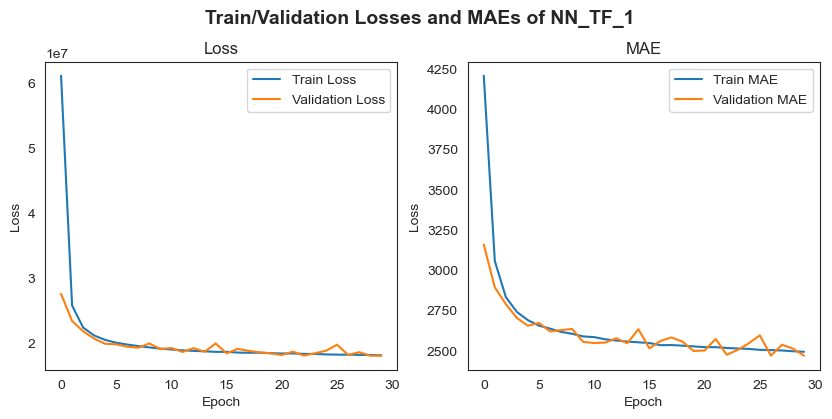

In [33]:
# Visualise the losses and MAEs
visualise_loss_mae(history_3.history, model_name)

We can observe that the losses and MAE scores have been fluctuating after 10 epochs. This can be due to the learning rate was too high for the model. Let's try to reduce the learning for every 10 epochs and retrain the model for more epochs.

**Model 4 - Neural Network (Tensorflow) - Reduce Learning Rate for Every 10 Epochs, More Epochs**

In [34]:
# Set up for the modeling process
model_name = 'NN_TF_2'
model_path = os.path.join(model_folder, f'{model_name}.keras')

In [35]:
# For reproducible result
tf.keras.utils.set_random_seed(42)

# Create the model
model_4 = Sequential()

# Add fully connected layers
model_4.add(Dense(16, activation='relu', input_shape=tf.expand_dims(X_train.shape[1], 0)))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(64, activation='relu'))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dense(16, activation='relu'))

# Final layer for prediction
model_4.add(Dense(1, activation='linear'))

In [36]:
# Compile the model
optimizer = Adam()
model_4.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [37]:
# Define a learning rate scheduler
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0.5,
    staircase=True
)

lr_scheduler = LearningRateScheduler(lr_schedule)

In [38]:
%%time
# Train the model for 50 epochs
history_4 = model_4.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[lr_scheduler])

Epoch 1/50
6566/6566 [==============================] - 11s 1ms/step - loss: 61214188.0000 - mae: 4209.6118 - val_loss: 27570754.0000 - val_mae: 3160.6270 - lr: 0.0010
Epoch 2/50
6566/6566 [==============================] - 10s 1ms/step - loss: 25789868.0000 - mae: 3057.8511 - val_loss: 23397552.0000 - val_mae: 2893.5835 - lr: 0.0010
Epoch 3/50
6566/6566 [==============================] - 10s 1ms/step - loss: 22377188.0000 - mae: 2833.1238 - val_loss: 21797478.0000 - val_mae: 2790.1230 - lr: 0.0010
Epoch 4/50
6566/6566 [==============================] - 9s 1ms/step - loss: 21154394.0000 - mae: 2741.1316 - val_loss: 20675780.0000 - val_mae: 2703.4832 - lr: 0.0010
Epoch 5/50
6566/6566 [==============================] - 9s 1ms/step - loss: 20472892.0000 - mae: 2689.9778 - val_loss: 19872760.0000 - val_mae: 2655.5454 - lr: 0.0010
Epoch 6/50
6566/6566 [==============================] - 9s 1ms/step - loss: 20034214.0000 - mae: 2655.9714 - val_loss: 19798084.0000 - val_mae: 2672.6133 - lr: 0.

In [39]:
# Show the validation MAE score
print(f'The validation MAE score of {model_name}: {history_4.history["val_mae"][-1]:.2f}')

The validation MAE score of NN_TF_2: 2475.61


In [40]:
# Store the result
result[model_name] = {}
result[model_name]['val_mae'] = history_4.history["val_mae"][-1]
best_model[model_name] = model_4

# Delete the model if it exists
if os.path.isfile(model_path):
    os.remove(model_path)

# Save the model
best_model[model_name].save(model_path)
if os.path.isfile(model_path):
    print(f'The {model_name} model has been saved.')

The NN_TF_2 model has been saved.


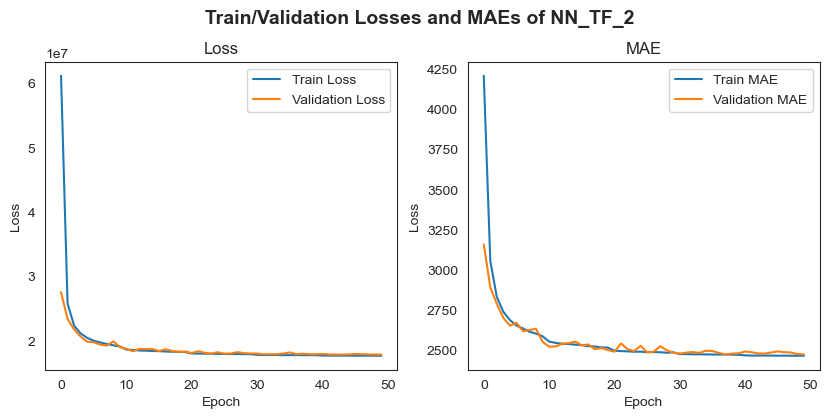

In [41]:
# Visualise the losses and MAEs
visualise_loss_mae(history_4.history, model_name)

The model learned more steadily with the adjusted learning rate for every 10 epochs.

**Model 5 - Neural Network (PyTorch)**

Let's recreate the model 4 in the PyTorch framework.

In [42]:
# Convert the data to tensor
X_train_pt = torch.tensor(X_train, dtype=torch.float32)
y_train_pt = torch.tensor(y_train, dtype=torch.float32)

X_val_pt = torch.tensor(X_val, dtype=torch.float32)
y_val_pt = torch.tensor(y_val, dtype=torch.float32)

X_test_pt = torch.tensor(X_test, dtype=torch.float32)
y_test_pt = torch.tensor(y_test, dtype=torch.float32)

In [43]:
# Set up for the modeling process
model_name = 'NN_PT_1'
model_path = os.path.join(model_folder, f'{model_name}.pt')

In [44]:
# Define the model
class torch_nn(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Create a sequential model
        self.layers = nn.Sequential(
            nn.Linear(in_features=X_train_pt.shape[1], out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )

    def forward(self, x):
        return self.layers(x)

In [45]:
# For reproducible rsult
np.random.seed(42)
torch.manual_seed(42)

# Create the model
model_5 = torch_nn()

# Have a look at the architecture of the neural network
model_5

torch_nn(
  (layers): Sequential(
    (0): Linear(in_features=37, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
    (10): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [46]:
# Set up the optimizer and loss function
opt = torch.optim.Adam(model_5.parameters())
loss_fn = nn.MSELoss()

# Set up the lr scheduler
lr_scheduler_pt = StepLR(opt, step_size=10, gamma=0.5)

# Set up the mae function
mae_fn = nn.L1Loss()

In [47]:
%%time
# Set up the training batches
train_dataset = TensorDataset(X_train_pt, y_train_pt)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# To store the training history
history_pt ={
    'loss': [],
    'mae': [],
    'val_loss': [],
    'val_mae':[]
}

# Set up the training loop
epochs = 50

for epoch in tqdm(range(epochs), desc=f'Training {model_name} model... '):
    model_5.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        batch_pred = model_5(X_batch).squeeze()
        loss = loss_fn(batch_pred, y_batch)               
        train_loss += loss
        
        opt.zero_grad()
        loss.backward()
        opt.step()

    train_loss /= len(train_loader)
    
    model_5.eval()
    with torch.inference_mode():
        y_pred = model_5(X_train_pt).squeeze()
        train_mae = mae_fn(y_pred, y_train_pt)
        
        y_val_pred = model_5(X_val_pt).squeeze()
        val_loss = loss_fn(y_val_pred, y_val_pt)
        val_mae = mae_fn(y_val_pred, y_val_pt)  

    # Store the current learning_rate to print
    current_lr = opt.param_groups[0]['lr']
    
    # Adjust the learning rate
    lr_scheduler_pt.step()

    # Store the result
    history_pt['loss'].append(train_loss.item())
    history_pt['mae'].append(train_mae.item())
    history_pt['val_loss'].append(val_loss.item())
    history_pt['val_mae'].append(val_mae.item())

    # Print the result for every 5 epochs
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f'Epoch {epoch+1} loss: {train_loss:.2f} | mae: {train_mae:.2f} | ', end='')
        print(f'val_loss: {val_loss:.2f} | val_mae: {val_mae:.2f} | lr: {current_lr}')

Training NN_PT_1 model... :   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 loss: 62106804.00 | mae: 3126.06 | val_loss: 27252642.00 | val_mae: 3108.77 | lr: 0.001
Epoch 5 loss: 21955898.00 | mae: 2711.36 | val_loss: 21310010.00 | val_mae: 2709.09 | lr: 0.001
Epoch 10 loss: 20069162.00 | mae: 2594.86 | val_loss: 19751490.00 | val_mae: 2597.70 | lr: 0.001
Epoch 15 loss: 19158172.00 | mae: 2562.75 | val_loss: 19254052.00 | val_mae: 2568.58 | lr: 0.0005
Epoch 20 loss: 18839364.00 | mae: 2542.69 | val_loss: 18618462.00 | val_mae: 2545.21 | lr: 0.0005
Epoch 25 loss: 18463032.00 | mae: 2523.99 | val_loss: 18538986.00 | val_mae: 2533.49 | lr: 0.00025
Epoch 30 loss: 18357436.00 | mae: 2521.34 | val_loss: 18357434.00 | val_mae: 2528.24 | lr: 0.00025
Epoch 35 loss: 18173430.00 | mae: 2506.74 | val_loss: 18280680.00 | val_mae: 2516.25 | lr: 0.000125
Epoch 40 loss: 18122506.00 | mae: 2498.83 | val_loss: 18217062.00 | val_mae: 2509.66 | lr: 0.000125
Epoch 45 loss: 18026160.00 | mae: 2493.55 | val_loss: 18196064.00 | val_mae: 2504.04 | lr: 6.25e-05
Epoch 50 loss: 18

In [48]:
# Show the validation MAE score
print(f'The validation MAE score of {model_name}: {history_pt["val_mae"][-1]:.2f}')

The validation MAE score of NN_PT_1: 2511.31


In [49]:
# Store the result
result[model_name] = {}
result[model_name]['val_mae'] = history_pt["val_mae"][-1]
best_model[model_name] = model_5

# Delete the model if it exists
if os.path.isfile(model_path):
    os.remove(model_path)

# Save the model
torch.save(model_5.state_dict(), model_path)
if os.path.isfile(model_path):
    print(f'The {model_name} model has been saved.')

The NN_PT_1 model has been saved.


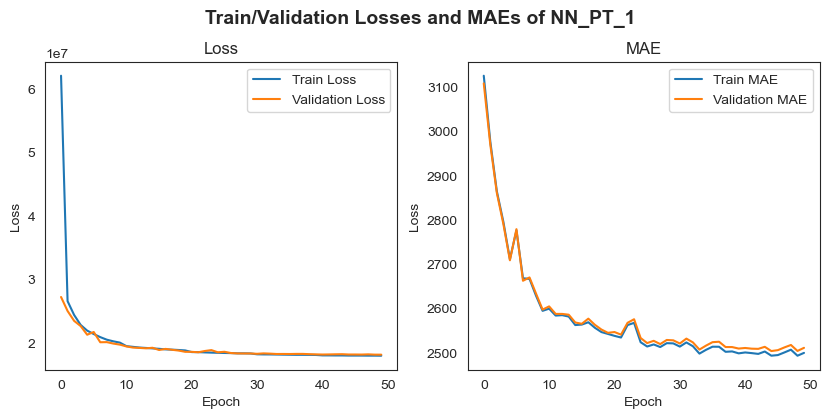

In [50]:
# Visualise the losses and MAEs
visualise_loss_mae(history_pt, model_name)

[Back to Contents](#back)

## 6. Model Evaluation <a id='evaluation'></a>

In [51]:
# Evaluate models
for model_name in result.keys():
    if model_name == 'NN_PT_1':
        model_5.eval()
        with torch.inference_mode():
            y_test_pred = model_5(X_test_pt).squeeze()
            result[model_name]['test_mae'] = mae_fn(y_test_pred, y_test_pt).item()
    elif model_name == 'LightGBM':
        y_test_pred = best_model[model_name].predict(X_test_lgbm)
        result[model_name]['test_mae'] = mean_absolute_error(y_test, y_test_pred)
    else:
        y_test_pred = best_model[model_name].predict(X_test)
        result[model_name]['test_mae'] = mean_absolute_error(y_test, y_test_pred)

1407/1407 [==============================] - 1s 856us/step


In [52]:
# Have a look at the final result
result_df = pd.DataFrame(result).transpose().sort_values('test_mae')
result_df

,val_mae,test_mae
LightGBM,1275.723090,1280.355180
NN_TF_1,2469.097900,2475.813056
NN_TF_2,2475.614746,2490.118279
NN_PT_1,2511.312988,2530.058594
LinearRegression,4558.040979,4556.464474


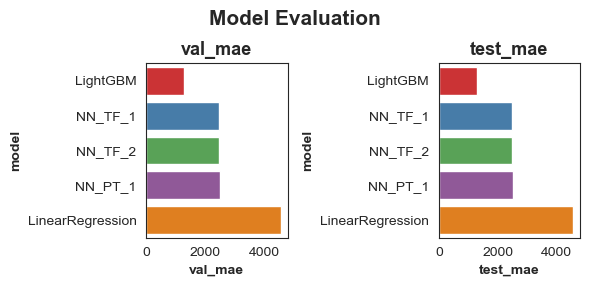

In [53]:
# Visualise the final result
plot_results = result_df.columns
nrows, ncols = 1, 2

sns.set_style('white')
fig, axs = plt.subplots(nrows, ncols, figsize=(6, 3))

plt.suptitle('Model Evaluation', fontsize=15, fontweight='bold', y=0.94)

# Assign colors for models
colors = sns.color_palette('Set1')
model_colors = {}
for i, model in enumerate(result_df.index):
    color = colors[i % len(colors)]
    model_colors[model] = color

for i in range(ncols):
    plot_name = plot_results[i]
    plot_data = result_df[[plot_name]].sort_values(plot_name)

    ax = axs[i]
    sns.barplot(y=plot_data.index, x=plot_data[plot_name], palette=model_colors, hue=plot_data.index, ax=ax)        
    ax.set_title(plot_name, fontsize=13, fontweight='bold')
    ax.set_xlabel(plot_name, fontweight='bold')
    ax.set_ylabel('model', fontweight='bold')
        
plt.tight_layout()
plt.show()

The LightGBM model which has both the lowest validatation and test MAE scores should fulfill the requirement of Fly Anywhere travel agency.

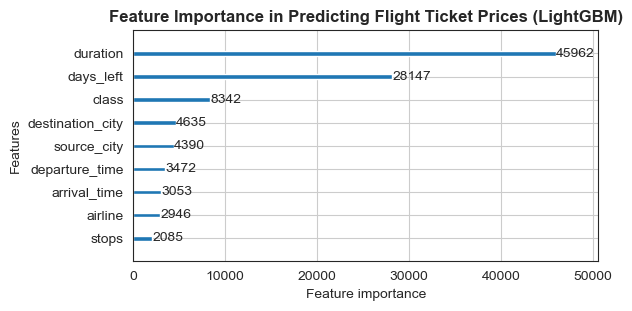

In [54]:
# Check the feature importance of lightgbm model
plot_importance(best_model['LightGBM'], figsize=(6, 3))
plt.title('Feature Importance in Predicting Flight Ticket Prices (LightGBM)', fontweight='bold')
plt.show()

The `duration` and `days_left` are two of the most important features to predict flight ticket prices.

[Back to Contents](#back)

## 7. Conclusion <a id='conclusion'></a>

The dataset contains around 300000 flight ticket purchase records. The dataset is clean and do not need any preprocessing. A total of five models have been developed to predict the flight ticket prices. The linear regression model has the worst MAE scores while the lightgbm model has the best MAE scores. The neural network models have moderate performances as expected. Usually, the neural network models will only shine when the dataset is huge enough and the features are complex, which is not the case for this dataset.